# Temps / Erreur (PINNs,Corr,FEM)

In [1]:
# sélection du cas test
testcase = 2
version = 1
degree = 1
n_params = 10

**Idée :** On se place dans un des Cas tests suivants : 1,1_v2,2.

On considère un ensemble de paramètres.

On cherche à calculer les temps moyens et les erreurs moyennes obtenus pour le PINNs, la Correction et FEM.

On testera pour différents $N$.

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import dataframe_image as dfi

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.solver_fem import FEMSolver
from modules.utils import create_tree
from modules.fenics_expressions import UexExpr


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/u2/lecourtier/miniconda3/envs/test_phifem/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Using device: cpu


In [4]:
if testcase == 1:
    if version == 1:
        from modules.testcases.d2.test_1.test_1_v1 import Run_laplacian2D,Poisson_2D
    elif version == 2:
        from modules.testcases.d2.test_1.test_1_v2 import Run_laplacian2D,Poisson_2D
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase1
    problem = TestCase1()
elif testcase == 2:
    from modules.testcases.d2.test_2.test_2_v1 import Run_laplacian2D,Poisson_2D
    from modules.problem import TestCase2
    problem = TestCase2()
else:
    raise ValueError("Testcase not found")

dim_params = problem.nb_parameters
result_dir = "../../../results/2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/corr/"
create_tree(result_dir)

torch loaded; device is cpu


0.0   1.5
0.0   10.0
>> load network /home/u2/lecourtier/Article1/networks/test_fe2.pth
jsbdbshd
network loaded


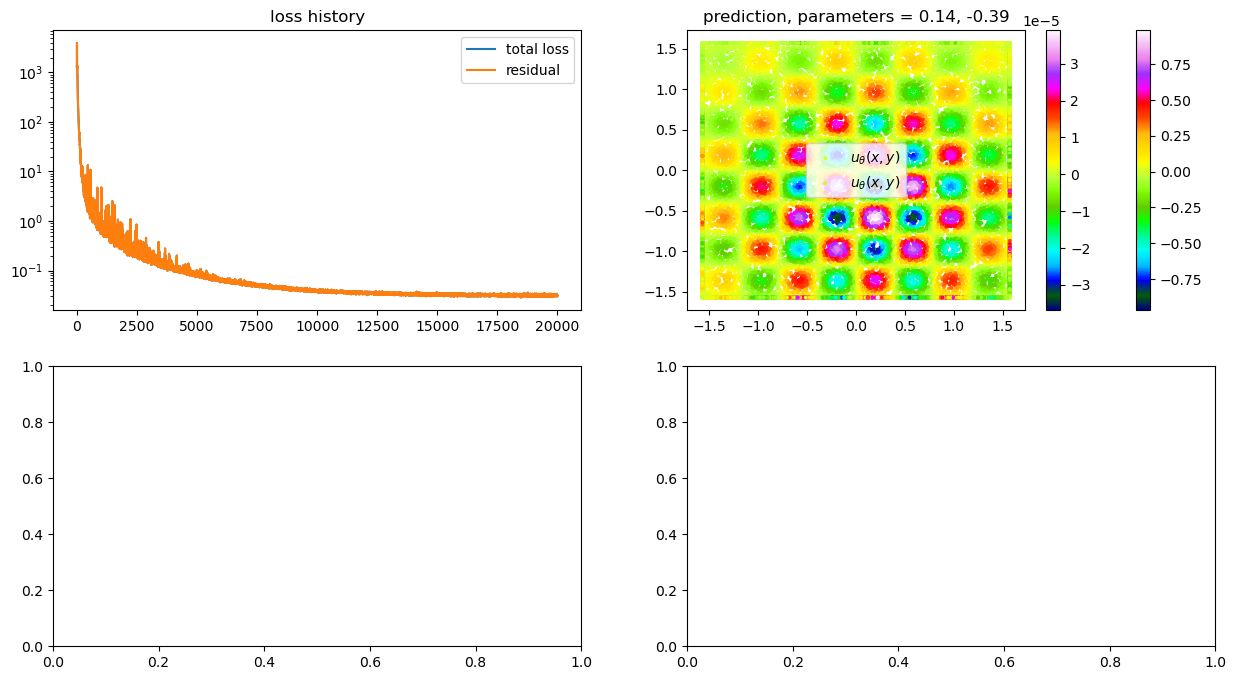

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_params(n):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick n random parameters for each dimension
    params = []
    for i in range(dim_params):
        parami = np.random.uniform(parameter_domain[i][0], parameter_domain[i][1], n)
        params.append(parami)
    params = np.array(params).T
    return params

np.random.seed(0)
params = get_params(n_params)
params_str = np.array([f"{params[i][0].round(2)},{params[i][1].round(2)}" for i in range(n_params)])
params

array([[ 0.04881405,  0.29172583],
       [ 0.21519008,  0.02889545],
       [ 0.10276398,  0.06804513],
       [ 0.04488373,  0.42559756],
       [-0.07634478, -0.42896387],
       [ 0.14589476, -0.41287061],
       [-0.06241235, -0.47978158],
       [ 0.39177389,  0.33262068],
       [ 0.46366372,  0.27815753],
       [-0.1165581 ,  0.37001302]])

## Temps/Erreur moyenne PINNs+Corr

In [7]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [8]:
degree_PINNs = 10

def read_csv_Corr(testcase,nb_vert):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_degree{degree}_N{nb_vert}.csv')
    tab_err_PINNs = list(df_Corr['err_PINNs'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    tab_times_Corr = list(df_Corr['times'].values)
    tab_subtimes_Corr = {}
    for key in df_Corr.keys():
        if key not in ['degree_PINNs', 'err', 'times']:
            tab_subtimes_Corr[key] = list(df_Corr[key].values)
    
    return df_Corr, tab_err_PINNs, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr

def run_Corr(nb_vert = 20,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_degree{degree}_N{nb_vert}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr, tab_err_PINNs, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr = read_csv_Corr(testcase,nb_vert)
        print(f"Read csv file {csv_file}")
    else:        
        tab_err_PINNs = []
        tab_err_Corr = []
        tab_times_Corr = []
        tab_subtimes_Corr = {}
        
        solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
        for i in range(n_params):
            print("#### i = ",i)
            
            V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_PINNs)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            
            u_ex = UexExpr(params[i], degree=solver.high_degree, domain=solver.mesh, pb_considered=solver.pb_considered)
                
            uref_Vex = df.interpolate(u_ex,V_test)
            norme_L2_PINNs = (df.assemble((((uref_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))
            tab_err_PINNs.append(norme_L2_PINNs)
            
            print(f"nb_vert={nb_vert}, norme_L2_PINNs={norme_L2_PINNs}")
            _,_,norme_L2 = solver.corr_add(i,u_PINNs)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)

            times_Corr = solver.times_corr_add
            for key in times_Corr:
                if key in tab_subtimes_Corr:
                    tab_subtimes_Corr[key].append(times_Corr[key])
                else:
                    tab_subtimes_Corr[key] = [times_Corr[key]]
            print(times_Corr.values())
            
            # times_Corr.__delitem__("system")
            total = sum(times_Corr.values())
            print(f"total time: {total}")
            tab_times_Corr.append(total)
        
        df_Corr = pd.DataFrame({'err_PINNs': tab_err_PINNs,'err': tab_err_Corr, 'times': tab_times_Corr, **tab_subtimes_Corr})       
        df_Corr.to_csv(csv_file, index=False)  
            
    return df_Corr, tab_err_PINNs, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr

In [9]:
tab_nb_vert_Corr = [20]

for nb_vert in tab_nb_vert_Corr:
    print("############ nb_vert =",nb_vert,"############")
    df_Corr, tab_err_PINNs, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr = run_Corr(nb_vert=nb_vert)
    
    df_Corr_ = df_Corr.copy()
    df_Corr_ = df_Corr_.rename(columns={"times": "TOTAL"})
    df_Corr_ = df_Corr_.reindex(columns = ["err_PINNs","err","mesh","assemble","solve","TOTAL"])
    
    csv_file = result_dir+f'Corr_mean_case{testcase}_degree{degree}_N{nb_vert}.csv'
    df_Corr_mean = df_Corr_.mean()
    df_Corr_mean.to_csv(csv_file,header=False)
    df_Corr_mean

############ nb_vert = 20 ############
Read csv file ../results/testcase2/corr/Corr_case2_degree1_N20.csv


## Temps/Erreur moyenne FEM

In [10]:
def read_csv_FEM(testcase,nb_vert):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_degree{degree}_N{nb_vert}.csv')
    tab_err_FEM = list(df_FEM['err'].values)
    tab_times_FEM = list(df_FEM['times'].values)
    tab_subtimes_FEM = {}
    for key in df_FEM.keys():
        if key not in ['degree_PINNs', 'err', 'times']:
            tab_subtimes_FEM[key] = list(df_FEM[key].values)
    
    return df_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM

def run_FEM(nb_vert,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_degree{degree}_N{nb_vert}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM = read_csv_FEM(testcase,nb_vert)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_FEM = []
        tab_times_FEM = []
        tab_subtimes_FEM = {}
        
        solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
        for i in range(n_params):
            print("#### i = ",i)
            
            _,norme_L2 = solver.fem(i)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)

            times_FEM = solver.times_fem
            for key in times_FEM:
                if key in tab_subtimes_FEM:
                    tab_subtimes_FEM[key].append(times_FEM[key])
                else:
                    tab_subtimes_FEM[key] = [times_FEM[key]]
            print(times_FEM.values())
            
            total = sum(times_FEM.values())
            print(f"total time: {total}")
            tab_times_FEM.append(total)
        
        df_FEM = pd.DataFrame({'err': tab_err_FEM, 'times': tab_times_FEM, **tab_subtimes_FEM})       
        df_FEM.to_csv(csv_file, index=False)  
            
    return df_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM

In [11]:
tab_nb_vert_FEM = [160,320]

for nb_vert in tab_nb_vert_FEM:
    print("############ nb_vert =",nb_vert,"############")
    df_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM = run_FEM(nb_vert = nb_vert)
    
    df_FEM_ = df_FEM.copy()
    df_FEM_ = df_FEM_.rename(columns={"times": "TOTAL"})
    df_FEM_ = df_FEM_.reindex(columns = ["err","mesh","assemble","solve","TOTAL"])
    
    csv_file = result_dir+f'FEM_mean_case{testcase}_degree{degree}_N{nb_vert}.csv'
    df_FEM_mean = df_FEM_.mean()
    df_FEM_mean.to_csv(csv_file,header=False)

############ nb_vert = 160 ############
Read csv file ../results/testcase2/corr/FEM_case2_degree1_N160.csv
############ nb_vert = 320 ############
Read csv file ../results/testcase2/corr/FEM_case2_degree1_N320.csv


## Tableau Temps/Erreur (PINNs+Corr+FEM)

In [12]:
def convert_hours(temps):
    temps_ = np.round(temps, 0)
    temps_ = temps_.astype(int)

    # create string with ..h..min..s (if needed)

    temps_str = []
    for time in temps_:
        time_str = ""
        if time >= 3600:
            time_str += str(time//3600) + "h"
            time = time % 3600
        if time >= 60:
            time_str += str(time//60) + "min"
            time = time % 60
        if time > 0:
            time_str += str(time) + "s"
        temps_str.append(time_str)
    
    return temps_str

In [13]:
tab_err_mean_Corr = []
tab_time_mean_Corr = []
for nb_vert in tab_nb_vert_Corr:
    csv_file = result_dir+f'Corr_mean_case{testcase}_degree{degree}_N{nb_vert}.csv'
    df_Corr_mean = pd.read_csv(csv_file,header=None)
    name = df_Corr_mean[0].values
    data = df_Corr_mean[1].values
    df_Corr_mean = pd.Series(data,name)
    
    err_mean_PINNs = df_Corr_mean["err_PINNs"]
    tab_err_mean_Corr.append(df_Corr_mean["err"])
    tab_time_mean_Corr.append(df_Corr_mean["TOTAL"])
    
tab_err_mean_FEM = []
tab_time_mean_FEM = []
for nb_vert in tab_nb_vert_FEM:
    csv_file = result_dir+f'FEM_mean_case{testcase}_degree{degree}_N{nb_vert}.csv'
    df_FEM_mean = pd.read_csv(csv_file,header=None)
    name = df_FEM_mean[0].values
    data = df_FEM_mean[1].values
    df_FEM_mean = pd.Series(data,name)
    
    tab_err_mean_FEM.append(df_FEM_mean["err"])
    tab_time_mean_FEM.append(df_FEM_mean["TOTAL"])
    
erreurs = [err_mean_PINNs]+tab_err_mean_Corr+tab_err_mean_FEM
temps = tab_time_mean_Corr+tab_time_mean_FEM
temps_str = convert_hours(temps)
index = ["PINNs"]+[f"Corr {nb_vert}^2" for nb_vert in tab_nb_vert_Corr]+[f"FEM {nb_vert}^2" for nb_vert in tab_nb_vert_FEM]

In [14]:
df_FINAL = pd.DataFrame({"temps (s)":[None]+temps,"temps":["NaN"]+temps_str,"erreurs":erreurs},index=index)

def scientific_format(x):
    return f"{x:.2e}"

df_FINAL['erreurs'] = df_FINAL['erreurs'].apply(scientific_format)

In [15]:
df_FINAL

,temps (s),temps,erreurs
PINNs,NaN,NaN,2.40e-02
Corr 20^2,1.614415,2s,1.19e-03
FEM 160^2,113.944649,1min54s,7.79e-03
FEM 320^2,448.535415,7min29s,1.94e-03


In [16]:
# df_styled = df_FINAL.style.format("{:.2e}")
# result_file = f"TestCase{testcase}"
# dfi.export(df_styled,result_file+".png",dpi=1000)